In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np

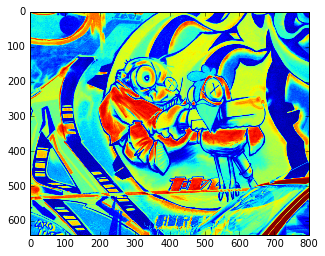

In [2]:
img = Image.open('/home/old-ufo/Dropbox/Mik/graf/img1.png').convert('RGB')
img = np.sum(np.array(img)/255.0, axis = 2)
plt.imshow(img)

In [3]:
var_image = torch.autograd.Variable(torch.from_numpy(img.astype(np.float32)))
var_image_reshape = var_image.view(1, 1, var_image.size(0),var_image.size(1))
#var_image_reshape = var_image_reshape.transpose(2,3).transpose(1,2)
var_image_reshape.shape

torch.Size([1, 1, 640, 800])

torch.Size([1, 1, 640, 800])

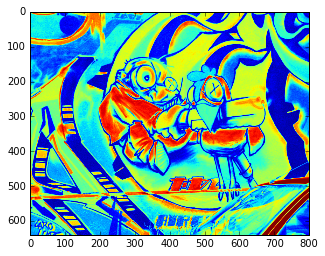

In [4]:
# notice that is has to be dtype=np.float32
indentity_theta = torch.autograd.Variable(torch.from_numpy(np.array([[1, 0, 0], [0, 1, 0]], dtype=np.float32)))
indentity_theta = indentity_theta.view(1,indentity_theta.size(0),indentity_theta.size(1))
grid = torch.nn.functional.affine_grid(indentity_theta, var_image_reshape.size())
out_image = torch.nn.functional.grid_sample(var_image_reshape,grid)
#Reshape channel for imshow
out_image_np = out_image.data.numpy()
out_image_np = np.squeeze(out_image_np)
out_image_np = out_image_np#.transpose([1,2,0])
plt.imshow(out_image_np)

In [5]:
indentity_theta

Variable containing:
(0 ,.,.) = 
  1  0  0
  0  1  0
[torch.FloatTensor of size 1x2x3]

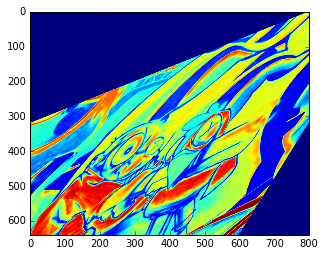

In [6]:

# notice that is has to be dtype=np.float32
indentity_theta = torch.autograd.Variable(torch.from_numpy(np.array([[1, 0.5, 0.01], [0.5, 1, -0.5]], dtype=np.float32)))
indentity_theta = indentity_theta.view(1,indentity_theta.size(0),indentity_theta.size(1))
grid = torch.nn.functional.affine_grid(indentity_theta, var_image_reshape.size())
out_image = torch.nn.functional.grid_sample(var_image_reshape,grid)
#Reshape channel for imshow
out_image_np = out_image.data.numpy()
out_image_np = np.squeeze(out_image_np)
out_image_np = out_image_np#.transpose([1,2,0])
plt.imshow(out_image_np)

In [8]:
var_image_reshape = var_image_reshape.cuda()


In [9]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super(SpatialTransformer, self).__init__()
        self.spatial_transformer_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 6, kernel_size=8, bias = True),
            nn.Tanh()
        )
        self.indentity_theta = torch.autograd.Variable(torch.from_numpy(np.array([[1, 0, 0], [0, 1, 0]], dtype=np.float32))).cuda()
        self.indentity_theta = self.indentity_theta.view(1,self.indentity_theta.size(0),self.indentity_theta.size(1))
        return
    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)

    def forward(self, input):
        input_norm_patches = self.input_norm(input)
        transform = 0.2 * self.spatial_transformer_net(input_norm_patches)
        transform = transform.view(transform.size(0), 2,3)
        transform = transform + self.indentity_theta.expand_as(transform)
        grid = torch.nn.functional.affine_grid(transform, input_norm_patches.size())
        transformed_image = torch.nn.functional.grid_sample(input_norm_patches,grid)
        return transformed_image


In [10]:
def fold_image_back(patches, original_image, stride, idx_show = 180 ):
    #print out_image_np.shape
    oi = np.zeros(original_image.shape);
    h,w = oi.shape
    num,ch,ps,ps2 = patches.shape
    idx = 0
    for j in range(h / (stride  * 4 )):
        for i in range(w / (stride  * 4 )):
            oi[ps*j:ps*(j+1),ps*i:ps*(i+1)] =  patches[idx ,0,:,:]
            if idx == idx_show:
                print (ps*j + ps*(j+1))/2, (ps*i + ps*(i+1))/2
            idx+=1
    return oi
class SpatialTransformer2d(nn.Module):
    def __init__(self, grid_patch_size = 32, stride = 8, min_zoom = 1.0,
                 max_zoom = 2.0 , min_tilt = 1.0, max_tilt = 2.0, max_rot = np.pi,  max_shift = 0.5 ):
        super(SpatialTransformer2d, self).__init__()
        self.grid_patch_size = grid_patch_size;
        self.stride = stride;
        self.spatial_transformer_feature_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU()
        )
        self.real_stride = 2 * 2 * self.stride;# num of strides in ST net
        self.max_rot = max_rot;
        self.min_zoom = min_zoom;
        self.min_tilt = min_tilt;
        self.max_zoom = max_zoom;
        self.max_tilt = max_tilt;
        self.max_shift = max_shift;
        self.psi_net =  nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=self.stride, bias = True, stride = self.stride),
            nn.Tanh()
        )
        self.theta_net = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=self.stride, bias = True, stride = self.stride),
            nn.Tanh()
        )
        self.shift_net = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=self.stride, bias = True, stride = self.stride),
            nn.Tanh()
        )
        self.iso_scale_net = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=self.stride, bias = True, stride = self.stride),
            nn.Tanh()
        )
        self.aniso_scale_net = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=self.stride, bias = True, stride = self.stride),
            nn.Tanh()
        )
        alpha = 0
        a11 = 1# np.cos(alpha)
        a12 = 0#np.sin(alpha)
        a13 = 0
        a21 = 0#-np.sin(alpha)
        a22 = 1#np.cos(alpha)
        a23 = 0
        self.indentity_theta = torch.autograd.Variable(torch.from_numpy(np.array([[a11,a12, a13], 
                                                                                  [a21, a22, a23]],
                                                                                 dtype=np.float32)))
        self.indentity_theta = self.indentity_theta.view(1,self.indentity_theta.size(0),
                                                         self.indentity_theta.size(1))
        self.eye2 = torch.autograd.Variable(torch.eye(2))
        self.eye2 = self.eye2.cuda()
        self.zero = torch.autograd.Variable(torch.zeros(1,1,1))
        self.zero = self.zero.cuda()
        self.one = torch.autograd.Variable(torch.ones(1,1,1))
        self.one = self.one.cuda()
        return
    def get_rotation_matrix(self, angle):
        angle = angle.view(-1, 1, 1);
        sin_a = torch.sin(angle)
        cos_a = torch.cos(angle)
        A1_x = torch.cat([cos_a, -sin_a], dim = 2)
        A2_x = torch.cat([sin_a, cos_a], dim = 2)
        transform = torch.cat([A1_x,A2_x], dim = 1)
        return transform
    def get_tilt_matrix(self, aniso_scale):
        an_s = aniso_scale.view(-1, 1, 1)
        A1_x = torch.cat((an_s, self.zero.expand_as(an_s)), dim = 2)
        A2_x = torch.cat([self.zero.expand_as(an_s), self.one.expand_as(an_s)], dim = 2)
        return torch.cat([A1_x,A2_x], dim = 1)
    def get_scale_matrix(self, iso_scale):
        iso_s = iso_scale.view(-1, 1, 1)
        A1_x = torch.cat((iso_s, self.zero.expand_as(iso_s)), dim = 2)
        A2_x = torch.cat([self.zero.expand_as(iso_s), iso_s], dim = 2)
        return torch.cat([A1_x,A2_x], dim = 1)
    def compose_affine_matrix(self, psi, theta, iso_scale, aniso_scale, shift):
        in_plane_rot =  self.get_rotation_matrix(psi);
        out_plane_rot = self.get_rotation_matrix(theta);
        tilt_matrix = self.get_tilt_matrix(aniso_scale);
        iso_scale = iso_scale.view(-1,1,1)
        A_iso_scale  = self.get_scale_matrix(iso_scale);
        A_iso_scale_in_plane = torch.bmm(A_iso_scale,in_plane_rot);
        A_tilt_out_of_place = torch.bmm(tilt_matrix, out_plane_rot)
        A_no_shift = torch.bmm(A_iso_scale_in_plane, A_tilt_out_of_place)
        return torch.cat([A_no_shift, shift.view(-1,2,1)], dim = 2)
    def unfold_patches_for_grid(self,input_image):
        self.pre_ps = int(self.max_tilt * self.max_zoom * self.grid_patch_size)
        needed_y = input_image.size(2) / self.real_stride
        needed_x = input_image.size(3) / self.real_stride
        needed_y_pad = (needed_y - 1) * self.real_stride + self.pre_ps - input_image.size(2)
        needed_x_pad = (needed_x - 1) * self.real_stride + self.pre_ps - input_image.size(3)
        padx_2 = needed_x_pad/2
        pady_2 = needed_y_pad/2
        half_ps =  self.pre_ps / 2
        inp_unfolded1 = nn.ZeroPad2d((padx_2,padx_2,
                                      pady_2,pady_2))(input_image).unfold(2, self.pre_ps, self.real_stride).squeeze(1);
        inp_unfolded2 = inp_unfolded1.unfold(2,self.pre_ps, self.real_stride).squeeze()
        inp_unfolded = inp_unfolded2.contiguous().view(-1,1,self.pre_ps,self.pre_ps)
        #print inp_unfolded1.shape, inp_unfolded2.shape, inp_unfolded.shape
        patch_centers_x = torch.arange(half_ps , input_image.size(3) + padx_2,
                                       step=self.real_stride) - padx_2;
        patch_centers_y = torch.arange(half_ps , input_image.size(2) + pady_2,
                                       step=self.real_stride) -  pady_2;
        patch_centers = torch.stack([patch_centers_x.repeat(patch_centers_y.size(0)), 
                                         patch_centers_y.repeat(patch_centers_x.size(0),1).t().contiguous().view(-1)],1)
        patch_centers = torch.autograd.Variable(patch_centers)
        patch_centers = patch_centers.cuda()
        return inp_unfolded, patch_centers

    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)
    def forward(self, input1):
        input_norm_patches = input1#self.input_norm(input1.contiguous())
        ST_features = self.spatial_transformer_feature_net(input_norm_patches)

        psi = self.max_rot * self.psi_net(ST_features)
        theta = self.max_rot * self.theta_net(ST_features)
        shift = self.max_shift * self.shift_net(ST_features) 
        tilt = torch.clamp(1.0 + (self.max_tilt - 1) * self.aniso_scale_net(ST_features),
                          min = self.min_tilt, max = self.max_tilt)
        scale = torch.clamp(1.0 + (self.max_zoom - 1) * self.iso_scale_net(ST_features),
                            min = self.min_zoom, max = self.max_zoom)

        transform = self.compose_affine_matrix(psi, theta, scale, tilt, shift)
        #print transform.shape
        #print transform
        grid = torch.nn.functional.affine_grid(transform, torch.Size((transform.size(0),
                                                           1,
                                                           self.grid_patch_size, 
                                                           self.grid_patch_size)))
        #print grid.shape
        inp_unfolded, patch_centers = self.unfold_patches_for_grid(input1);
        grid =  grid / float(self.pre_ps / self.grid_patch_size) # adjust grid for taking bigger input patch
        #to avoid empty places. Input patch size is calculates in unfold_patches_for_grid function
        
        
        transformed_patches = torch.nn.functional.grid_sample(inp_unfolded, grid)
        affine_matrices_out = self.grid_patch_size * transform
        print patch_centers.shape,affine_matrices_out[:,:,2].shape
        affine_matrices_out[:,:,2] =  patch_centers + affine_matrices_out[:,:,2];
        return transformed_patches, affine_matrices_out


torch.Size([30, 2]) torch.Size([30, 2])
(640, 800)


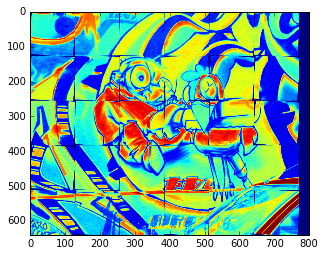

In [11]:
stride1 = 32

gps = 4*stride1
ConvST_net = SpatialTransformer2d(min_zoom = 1.0, max_zoom = 1.0, 
                                  min_tilt = 1.0, max_tilt = 1.0, 
                                  max_rot = 0.1, stride = stride1, grid_patch_size = gps,  max_shift = 0 )
ConvST_net.cuda()

out_image,aff_pts = ConvST_net(var_image_reshape)
out_image_np = out_image.data.cpu().numpy()
oi = fold_image_back(out_image_np, img, stride1)
print oi.shape
plt.imshow(oi)

192 576
(30, 1, 128, 128)


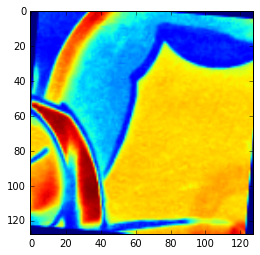

In [12]:
idx_to_show = 10;
oi = fold_image_back(out_image_np, img, stride1, idx_to_show)
print out_image_np.shape
plt.imshow(out_image_np[idx_to_show,0,:,:])

[[ 127.56309509   10.56674004  592.        ]
 [ -10.56674099  127.56309509  192.        ]]
(640, 800)


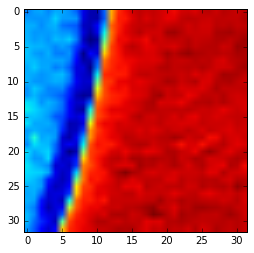

In [13]:
c = aff_pts.data.cpu().numpy()[idx_to_show,:,:]
print c
ppps_2 = 16;
print img.shape
plt.imshow(img[int(c[1,2] - ppps_2):int(c[1,2] + ppps_2), int(c[0,2] - ppps_2):int(c[0,2] + ppps_2)])

In [14]:
print out_image_np.shape

(30, 1, 128, 128)


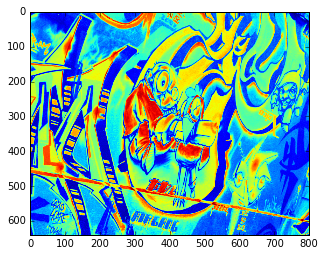

In [15]:
img2 = Image.open('/home/old-ufo/Dropbox/Mik/graf/img3.png').convert('RGB')
img2 = np.sum(np.array(img2)/255.0, axis = 2)
plt.imshow(img2)

In [17]:
var_image2 = torch.autograd.Variable(torch.from_numpy(img2.astype(np.float32))).cuda()
var_image_reshape2 = var_image2.view(1, 1, var_image2.size(0),var_image2.size(1))

torch.Size([30, 2]) torch.Size([30, 2])


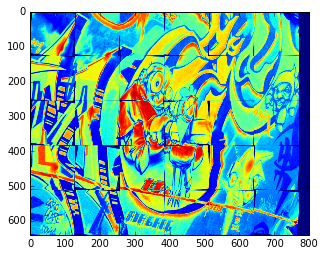

In [18]:

out_image2, aff_matr_2 = ConvST_net(var_image_reshape2)
out_image_np2 = out_image2.data.cpu().numpy()
oi2 = fold_image_back(out_image_np2, img2, stride1)
plt.imshow(oi2)

In [19]:
H1to2 = np.loadtxt('/home/old-ufo/Dropbox/Mik/graf/H1to3p')
print H1to2

[[  7.62858980e-01  -2.99229290e-01   2.25671230e+02]
 [  3.34434730e-01   1.01439010e+00  -7.69999730e+01]
 [  3.46630910e-04  -1.43645240e-05   1.00000000e+00]]


In [20]:
aff_pts1 = aff_pts.data.cpu().numpy()
aff_pts2 = aff_matr_2.data.cpu().numpy()
pt1_1 = aff_pts1[0,:,:]
pt1_2 = aff_pts2[0,:,:]
print pt1_1.shape

(2, 3)


In [21]:
pt1_1_H = np.concatenate([pt1_1, np.array([[0, 0, 1]])], axis = 0)
pt1_2_H = np.concatenate([pt1_2, np.array([[0, 0, 1]])], axis = 0)


In [22]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [23]:
pt1_2_H_to_1 = np.dot(H1to2, pt1_2_H)

print pt1_1_H
print pt1_2_H_to_1
H1to2_v = torch.autograd.Variable(torch.from_numpy(H1to2.astype(np.float32))).cuda()
def distance_matrix_vector(anchor, positive):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    d1_sq = torch.sum(anchor * anchor, dim=1)
    d2_sq = torch.sum(positive * positive, dim=1)
    eps = 1e-6
    return torch.sqrt((d1_sq.expand(anchor.size(0), anchor.size(0)) + torch.t(d2_sq.expand(positive.size(0), positive.size(0)))
                      - 2.0 * torch.bmm(positive.unsqueeze(0), torch.t(anchor).unsqueeze(0)).squeeze(0))+eps)

[[ 127.487   11.446   80.   ]
 [ -11.446  127.487   64.   ]
 [   0.       0.       1.   ]]
[[ 101.63   -25.944  267.549]
 [  26.437  134.136   14.676]
 [   0.044    0.004    1.027]]


In [24]:
def distance_matrix_vector4(anchor, positive):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    d1_sq = torch.sum(anchor * anchor, dim=1)
    d2_sq = torch.sum(positive * positive, dim=1)
    eps = 1e-6
    return torch.t(torch.sqrt((d1_sq.expand(anchor.size(0), anchor.size(0)) + torch.t(d2_sq.expand(positive.size(0), positive.size(0)))
                      - 2.0 * torch.bmm(positive.unsqueeze(0), torch.t(anchor).unsqueeze(0)).squeeze(0))+eps))
def distance_matrix_vector3(anchor, positive):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    d1_sq = torch.sum(anchor * anchor, dim=1).unsqueeze(-1)
    d2_sq = torch.sum(positive * positive, dim=1).unsqueeze(-1)

    eps = 1e-6
    return torch.sqrt((d1_sq.repeat(1, anchor.size(0)) + torch.t(d2_sq.repeat(1, positive.size(0)))
                      - 2.0 * torch.bmm(anchor.unsqueeze(0), torch.t(positive).unsqueeze(0)).squeeze(0))+eps)


In [25]:

def LAFs_to_H_frames(aff_pts):
    H3_x = torch.Tensor([0, 0, 1 ]).unsqueeze(0).unsqueeze(0).expand_as(aff_pts[:,0:1,:]);
    H3_x = torch.autograd.Variable(H3_x)
    H3_x = H3_x.cuda()
    return torch.cat([aff_pts, H3_x], dim = 1)
def get_GT_correspondence_indexes(aff_pts1,aff_pts2, H1to2, dist_threshold = 4):
    #LHF1 = LAFs_to_H_frames(aff_pts1)
    LHF2 = LAFs_to_H_frames(aff_pts2)
    LHF2_reprojected_to_1 = torch.bmm(H1to2.unsqueeze(0).expand_as(LHF2), LHF2);
    LHF2_reprojected_to_1 = LHF2_reprojected_to_1 / LHF2_reprojected_to_1[:,2:,2:].expand_as(LHF2_reprojected_to_1);
    just_centers1 = aff_pts1[:,:,2];
    just_centers2_repr_to_1 = LHF2_reprojected_to_1[:,0:2,2];
    #print just_centers1.shape
    dist  = distance_matrix_vector(just_centers1, just_centers2_repr_to_1)
    dist2 = distance_matrix_vector3(just_centers1, just_centers2_repr_to_1)
    dist3 = distance_matrix_vector4(just_centers1, just_centers2_repr_to_1)
    
    print dist2[0:5,0:5]
    print dist3[0:5,0:5]
    min_dist, idxs_in_2 = torch.min(dist,1)
    plain_indxs_in1 = torch.autograd.Variable(torch.arange(0, idxs_in_2.size(0))).cuda()
    mask =  min_dist <= dist_threshold
    return min_dist[mask], plain_indxs_in1[mask], idxs_in_2[mask]


In [26]:
dists, idxs_in1, idxs_in2 = get_GT_correspondence_indexes(aff_pts, aff_matr_2, H1to2_v, dist_threshold = 5);
#print gt_idxs

Variable containing:
 187.2804  261.1327  335.9003  407.5605  475.1652
  72.3445  133.3292  208.5152  281.5439  350.3482
  90.3411   11.4503   83.0433  158.7340  229.0717
 209.4214  123.5053   55.5138   62.4012  122.3594
 335.1434  251.2847  178.9844  123.9329  101.1821
[torch.cuda.FloatTensor of size 5x5 (GPU 0)]

Variable containing:
 187.2804  261.1327  335.9003  407.5605  475.1652
  72.3445  133.3292  208.5152  281.5439  350.3482
  90.3411   11.4503   83.0433  158.7340  229.0717
 209.4214  123.5053   55.5138   62.4012  122.3594
 335.1434  251.2847  178.9844  123.9329  101.1821
[torch.cuda.FloatTensor of size 5x5 (GPU 0)]



In [27]:
dists_np = dists.data.cpu().numpy()
idxs1_np = idxs_in1.data.cpu().numpy().astype(np.int32)
idxs2_np = idxs_in2.data.cpu().numpy().astype(np.int32)
print idxs1_np
idxs2_np

[]


array([], dtype=int32)

In [28]:
iii = 3
plt.figure()
plt.imshow(out_image_np[idxs1_np[iii],0,:,:])
plt.figure()
plt.imshow(out_image_np2[idxs2_np[iii],0,:,:])

#print idxs1_np[good_idxs], idxs2_np[good_idxs]

IndexError: index 3 is out of bounds for axis 0 with size 0

In [109]:
print idxs1_np[good_idxs][iii]

8.0


In [ ]:
class SparseImageRespesenter(nn.Module):
    """SIRNet model definition
    """
    def __init__(self):
        super(SparseImageRespesenter, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1, bias = False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 128, kernel_size=8, bias = False),
            nn.BatchNorm2d(128, affine=False),
        )
        self.features.apply(weights_init)
        return
    
    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.sum(flat, dim=1) / (32. * 32.)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)

    def forward(self, input):
        x_features = self.features(self.input_norm(input))
        x = x_features.view(x_features.size(0), -1)
        return L2Norm()(x)
